In [1]:
"""
Initial exploration into one day of fitbit heart rate data
"""

import json

import pandas as pd # Using pandas 1.0.1, will set up a venv soon
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

In [2]:
# Load heart rate data
# Exciting discovery! Some of the data is in UTC and some is in PST
fn = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/data_dump/user-site-export/heart_rate-2020-01-13.json"
with open(fn) as f:
  whyred = json.load(f)
whyred[0:5]

[{'dateTime': '01/13/20 08:00:07', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:22', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:37', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:52', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '01/13/20 08:01:07', 'value': {'bpm': 60, 'confidence': 3}}]

In [3]:
# Convert to dataframe
index = pd.to_datetime([x['dateTime'] for x in whyred])
print(index[0:5])
# Exciting discovery! Some of the data is in UTC and some is in PST.
# Heart rate is in UTC
index = [x - pd.Timedelta(8, unit='h') for x in index]
data = [[x['value']['bpm'], x['value']['confidence']] for x in whyred]

df = pd.DataFrame(data, index=index, columns=['bpm', 'confidence'])
df.head()

DatetimeIndex(['2020-01-13 08:00:07', '2020-01-13 08:00:22',
               '2020-01-13 08:00:37', '2020-01-13 08:00:52',
               '2020-01-13 08:01:07'],
              dtype='datetime64[ns]', freq=None)


,bpm,confidence
2020-01-13 00:00:07,59,3
2020-01-13 00:00:22,59,3
2020-01-13 00:00:37,59,3
2020-01-13 00:00:52,60,3
2020-01-13 00:01:07,60,3


In [4]:
# Size of data
df.shape

(10508, 2)

Text(0.5, 1.0, 'Distribution of heart rate over one day (2019-01-12)')

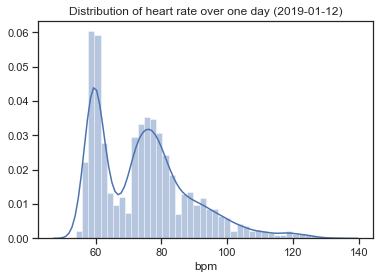

In [5]:
ax = sns.distplot(df["bpm"])
ax.set_title("Distribution of heart rate over one day (2019-01-12)")

(array([737437.   , 737437.125, 737437.25 , 737437.375, 737437.5  ,
        737437.625, 737437.75 , 737437.875, 737438.   ]),
 <a list of 9 Text xticklabel objects>)

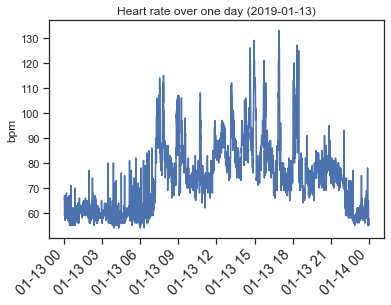

In [6]:
ax = sns.lineplot(x=df.index, y=df["bpm"])
ax.set_title("Heart rate over one day (2019-01-13)")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

In [7]:
# Ok let's predict resting vs. sleeping with a tensorflow HMM.
# Interestingly, tensorflow has HMMs implemented, assuming you already know the parameters
# But doesn't have methods implemented to infer parameters
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

initial_distribution = tfd.Categorical(probs=[0.66, 0.33])

transition_distribution = tfd.Categorical(probs=[[0.9, 0.1],
                                                 [0.1, 0.9]])

observation_distribution = tfd.Normal(loc=[63., 80.], scale=[3., 10.])

model = tfd.HiddenMarkovModel(
      initial_distribution=initial_distribution,
      transition_distribution=transition_distribution,
      observation_distribution=observation_distribution,
      num_steps=10508)

print(model.mean())
print(model.log_prob(tf.zeros(shape=[7])))
print(model)

tf.Tensor([68.666664 69.23333  69.68666  ... 71.49977  71.49977  71.49977 ], shape=(10508,), dtype=float32)
tf.Tensor(-248.18616, shape=(), dtype=float32)
tfp.distributions.HiddenMarkovModel("HiddenMarkovModel", batch_shape=[], event_shape=[10508], dtype=float32)


In [8]:
df["bpm"] = df["bpm"].astype(np.float32)
result = model.posterior_mode(df["bpm"])

In [9]:
(unique, counts) = np.unique(result.numpy(), return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 3933],
       [   1, 6575]])

In [10]:
# Add result to bpm
df["state"] = result.numpy()
df["datetime"] = df.index
df.head()

,bpm,confidence,state,datetime
2020-01-13 00:00:07,59.0,3,0,2020-01-13 00:00:07
2020-01-13 00:00:22,59.0,3,0,2020-01-13 00:00:22
2020-01-13 00:00:37,59.0,3,0,2020-01-13 00:00:37
2020-01-13 00:00:52,60.0,3,0,2020-01-13 00:00:52
2020-01-13 00:01:07,60.0,3,0,2020-01-13 00:01:07


                      bpm  confidence  state            datetime
2020-01-13 00:00:07  59.0           3      0 2020-01-13 00:00:07
2020-01-13 00:00:22  59.0           3      0 2020-01-13 00:00:22
2020-01-13 00:00:37  59.0           3      0 2020-01-13 00:00:37
2020-01-13 00:00:52  60.0           3      0 2020-01-13 00:00:52
2020-01-13 00:01:07  60.0           3      0 2020-01-13 00:01:07


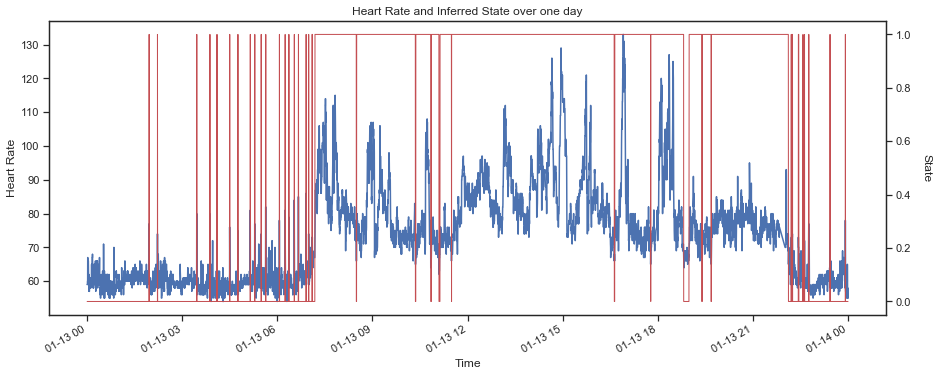

In [11]:
ax = df.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df.plot(x="datetime", y="state", ax=ax2, linewidth=1, legend=False, color="r")
plt.title("Heart Rate and Inferred State over one day")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")
print(df.head())

In [12]:
# Load what fitbit says about my sleep
fn = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/data_dump/user-site-export/sleep-2020-01-11.json"
with open(fn) as f:
   fitbit_sleep_all = json.load(f)
fitbit_sleep = [x for x in fitbit_sleep_all if x['dateOfSleep'] == "2020-01-14" or x['dateOfSleep'] == "2020-01-13"]
fitbit_sleep

[{'logId': 25432556062,
  'dateOfSleep': '2020-01-14',
  'startTime': '2020-01-13T22:31:00.000',
  'endTime': '2020-01-14T07:20:30.000',
  'duration': 31740000,
  'minutesToFallAsleep': 0,
  'minutesAsleep': 479,
  'minutesAwake': 50,
  'minutesAfterWakeup': 0,
  'timeInBed': 529,
  'efficiency': 97,
  'type': 'stages',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 5,
     'minutes': 99,
     'thirtyDayAvgMinutes': 62},
    'wake': {'count': 31, 'minutes': 50, 'thirtyDayAvgMinutes': 77},
    'light': {'count': 32, 'minutes': 303, 'thirtyDayAvgMinutes': 417},
    'rem': {'count': 8, 'minutes': 77, 'thirtyDayAvgMinutes': 32}},
   'data': [{'dateTime': '2020-01-13T22:31:00.000',
     'level': 'wake',
     'seconds': 1230},
    {'dateTime': '2020-01-13T22:51:30.000', 'level': 'light', 'seconds': 60},
    {'dateTime': '2020-01-13T22:52:30.000', 'level': 'deep', 'seconds': 1980},
    {'dateTime': '2020-01-13T23:25:30.000', 'level': 'light', 'seconds': 390},
    {'dateTime': '20

In [13]:
# Transform the fitbit data to get inferred sleep predictions
fitbit_sleep[0]['startTime']

'2020-01-13T22:31:00.000'

In [14]:
# Transform the fitbit data to get inferred sleep predictions
# Need to get this data into the same dataframe
fitbit_sleep[0]['levels']['data']

[{'dateTime': '2020-01-13T22:31:00.000', 'level': 'wake', 'seconds': 1230},
 {'dateTime': '2020-01-13T22:51:30.000', 'level': 'light', 'seconds': 60},
 {'dateTime': '2020-01-13T22:52:30.000', 'level': 'deep', 'seconds': 1980},
 {'dateTime': '2020-01-13T23:25:30.000', 'level': 'light', 'seconds': 390},
 {'dateTime': '2020-01-13T23:32:00.000', 'level': 'deep', 'seconds': 450},
 {'dateTime': '2020-01-13T23:39:30.000', 'level': 'light', 'seconds': 2490},
 {'dateTime': '2020-01-14T00:21:00.000', 'level': 'deep', 'seconds': 360},
 {'dateTime': '2020-01-14T00:27:00.000', 'level': 'light', 'seconds': 2010},
 {'dateTime': '2020-01-14T01:00:30.000', 'level': 'rem', 'seconds': 690},
 {'dateTime': '2020-01-14T01:12:00.000', 'level': 'light', 'seconds': 1260},
 {'dateTime': '2020-01-14T01:33:00.000', 'level': 'deep', 'seconds': 1740},
 {'dateTime': '2020-01-14T02:02:00.000', 'level': 'light', 'seconds': 2970},
 {'dateTime': '2020-01-14T02:51:30.000', 'level': 'rem', 'seconds': 570},
 {'dateTime': '

In [15]:
# Add the fitbit inferred values to the df
value_dict = {'wake': 1, 'light': 0, 'deep': -1, 'rem': -2}
df['fitbit'] = 1
for i in range(0, 2):
    for my_dict in fitbit_sleep[i]['levels']['data']:
        start = pd.Timestamp(my_dict['dateTime'])
        end = start + pd.Timedelta(my_dict['seconds'], unit='s')
        value_to_use = value_dict[my_dict['level']]
        if value_to_use != 1:
            df.loc[(df['datetime'] > start) & (df['datetime'] <= end), 'fitbit'] = value_to_use
print(df['fitbit'].value_counts())
print(df['state'].value_counts())

 1    7021
 0    2881
-1     403
-2     203
Name: fitbit, dtype: int64
1    6575
0    3933
Name: state, dtype: int64


Text(0.5, 0, 'Time')

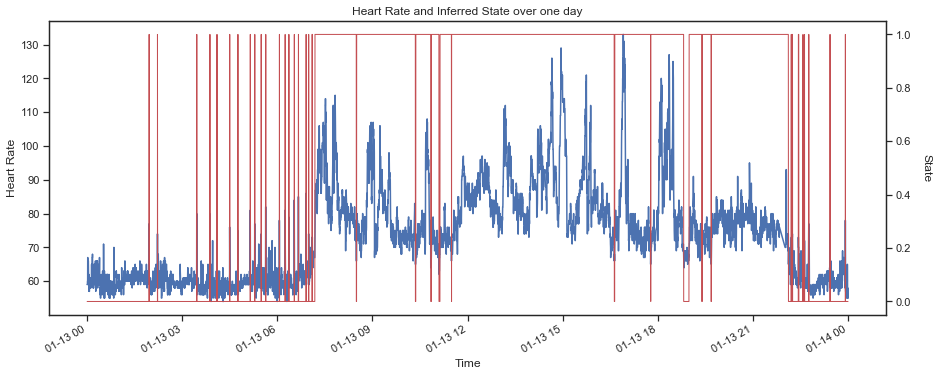

In [16]:
ax = df.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df.plot(x="datetime", y="state", ax=ax2, linewidth=1, legend=False, color="r")
plt.title("Heart Rate and Inferred State over one day")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")

                      bpm  confidence  state            datetime  fitbit
2020-01-13 00:00:07  59.0           3      0 2020-01-13 00:00:07      -1
2020-01-13 00:00:22  59.0           3      0 2020-01-13 00:00:22      -1
2020-01-13 00:00:37  59.0           3      0 2020-01-13 00:00:37      -1
2020-01-13 00:00:52  60.0           3      0 2020-01-13 00:00:52      -1
2020-01-13 00:01:07  60.0           3      0 2020-01-13 00:01:07      -1
...                   ...         ...    ...                 ...     ...
2020-01-13 23:59:27  57.0           3      0 2020-01-13 23:59:27       0
2020-01-13 23:59:32  56.0           3      0 2020-01-13 23:59:32       0
2020-01-13 23:59:42  57.0           3      0 2020-01-13 23:59:42       0
2020-01-13 23:59:47  56.0           3      0 2020-01-13 23:59:47       0
2020-01-13 23:59:52  55.0           3      0 2020-01-13 23:59:52       0

[10508 rows x 5 columns]


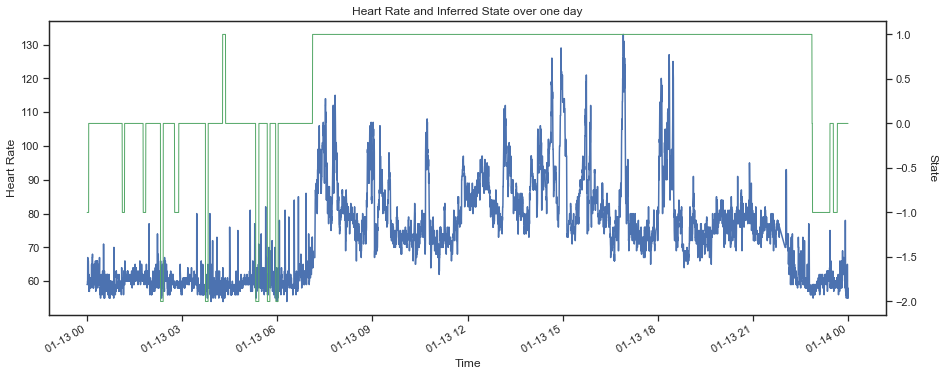

In [17]:
ax = df.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df.plot(x="datetime", y="fitbit", ax=ax2, linewidth=1, legend=False, color="g")
plt.title("Heart Rate and Inferred State over one day")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")
print(df)

In [18]:
# We can see a few problems with this model.
# The primary one is that it thinks I am sleeping at random points during the day.
# I never nap, so this is clearly not what is happening.
# I realize this is probably why fitbit requires "3 hours" of data
# before they decide to report on your sleep. They are looking for a consistent 3 hour signal.